# Modelo para apuestas Premier League

- El predictor está basado en el ELO rating, que usamos para estimar las probablidades
  de cada resultado.
- Se mantiene un rating global, uno que solo tienen en cuenta los partidos de local  
  y uno que solo tiene en cuenta los partidos de visitante.
- Primero cargamos en dataframes los datos de la temporada actual y la anterior, se usa  
  la temporada anterior para calcular los elos iniciales de la actual.

In [17]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import pandasql as pdsql
import matplotlib.pyplot as plt
import sys

# PARAMETERS
# ------------------------------------------------------------------------------
K: int = 36  # ELO K-factor
N_BETS: int = 380  # Number of bets to simulate
HTA: int = 150  # Home team advantage
EV_CUTOFF: float = 0.6  # Cutoff to place bets on
FORM_MEMORY: int = 10  # Number of previous matches to remember
FORM_MULTIPLIER = 12.5
# ------------------------------------------------------------------------------

# current_season: str = f"{sys.argv[1]}-{int(sys.argv[2]) - 2000}"
# last_season: str = f"{int(sys.argv[1]) - 1:02d}-{int(sys.argv[1]) - 2000:02d}"

current_season: str = "2016-17"
last_season: str = "2015-16"

full_df: pd.DataFrame = pd.read_csv(f"Datasets/premier/{current_season}.csv")
last_season_ds: pd.DataFrame = pd.read_csv(f"Datasets/premier/{last_season}.csv")
full_df.reset_index(drop=True, inplace=True)
full_df.head(20)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50
5,E0,13/08/16,Middlesbrough,Stoke,1,1,D,1,0,H,...,1.53,32,-0.25,1.99,1.93,1.97,1.92,2.20,3.38,3.70
6,E0,13/08/16,Southampton,Watford,1,1,D,0,1,A,...,1.75,33,-0.75,2.16,2.07,1.89,1.80,1.80,3.83,4.91
7,E0,14/08/16,Arsenal,Liverpool,3,4,A,1,1,D,...,1.99,31,-0.50,2.41,2.31,1.81,1.64,2.80,3.44,2.68
8,E0,14/08/16,Bournemouth,Man United,1,3,A,0,1,A,...,1.76,33,0.75,1.80,1.76,2.17,2.11,5.40,3.65,1.78
9,E0,15/08/16,Chelsea,West Ham,2,1,H,0,0,D,...,2.01,33,-1.00,2.20,2.10,1.80,1.76,1.52,4.38,7.45


- Definimos funciones  para manipular rating.

In [18]:
def get_expected_score(rating_1: int, rating_2: int) -> float:
  return 1 / (1 + 10**((rating_2 - rating_1) / 400))

def get_new_elo(rating_1: int, rating_2: int, score_1: int, score_2: int) -> Tuple[int, int]:
    """
    Calculates new elo ratings for both teams.
    """
    # Calculate expected score for both teams
    expected_score_1: float = get_expected_score(rating_1, rating_2)
    expected_score_2: float = get_expected_score(rating_2, rating_1)

    # Calculate new elo ratings
    result1 : float = 1 if score_1 > score_2 else 0.5 if score_1 == score_2 else 0
    result2 : float = 1 - result1

    new_rating_1: int = round(rating_1 + K * (result1 - expected_score_1))
    new_rating_2: int = round(rating_2 + K * (result2 - expected_score_2))

    # Bonus por golear/ Penalización por ser goleado
    bonus_rating_1: float = 0
    bonus_rating_2: float = 0

    if (score_1 - score_2 > 2):
        bonus_rating_1 = score_1 - score_2
        bonus_rating_2 = score_2 - score_1
    elif (score_2 > score_1 > 2):
        bonus_rating_2 = int((score_2 - score_1) * 1.5)
        bonus_rating_1 = int((score_1 - score_2) * 1.5)

    return (new_rating_1 + bonus_rating_1, new_rating_2 + bonus_rating_2)


- Se juntan los equipos que participaron en la temporada   
  anterior y actual en un solo dataframe.
- Se calculan los ratings al terminar la temporada anterior.
- A cada equipo se le asigna un rating inicial de 1200.

In [19]:
df_teams = pdsql.sqldf("SELECT DISTINCT HomeTeam as TEAM FROM full_df UNION SELECT DISTINCT HomeTeam as TEAM from last_season_ds")
df_teams["RATING"] = df_teams["H_RATING"] = df_teams["A_RATING"] = 1200

for index, row in last_season_ds.iterrows():
  new_elos: Tuple[int, int] = get_new_elo(df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "RATING"].values[0],
                                          df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "RATING"].values[0],
                                          row["FTHG"], row["FTAG"])
  new_elos_localia: Tuple[int, int] = get_new_elo(df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"].values[0],
                                                 df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"].values[0],
                                                 row["FTHG"], row["FTAG"])
                                                 
  df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "RATING"] = new_elos[0]
  df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "RATING"] = new_elos[1]

  df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"] = new_elos_localia[0]
  df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"] = new_elos_localia[1]

for index, row in df_teams.iterrows():
  df_teams.loc[index, "RATING"] = (row["RATING"] + 1200) / 2
  df_teams.loc[index, "H_RATING"] = (row["H_RATING"] + 1200) / 2
  df_teams.loc[index, "A_RATING"] = (row["A_RATING"] + 1200) / 2 
df_teams.head(25)

,TEAM,RATING,H_RATING,A_RATING
0,Arsenal,1250.0,1252.5,1221.0
1,Aston Villa,1090.5,1140.5,1110.5
2,Bournemouth,1167.0,1174.0,1184.5
3,Burnley,1200.0,1200.0,1200.0
4,Chelsea,1216.0,1204.0,1208.0
5,Crystal Palace,1155.0,1176.5,1175.0
6,Everton,1180.0,1188.5,1188.5
7,Hull,1200.0,1200.0,1200.0
8,Leicester,1288.0,1266.5,1254.0
9,Liverpool,1230.5,1237.5,1204.0


- Luego convertimos las odds de nuestro proveedor a probabilidad, columnas PB365H, PB365D y PB365A,  
  normalizando para que la suma de resultados posibles sea 1, ya que la suma da mayor a 1 por el  
  margen que se dejan los bookmakers.
- Se carga cada partido, actualizando el elo y forma, dejando registro del rating de cada equipo  
  en ese partido y de la forma en la que llegaron al partido (ultimos resultados).
- Se actualizan las columnas de jugados, ganados, empatados y perdidos de cada equipo.

In [20]:
df_teams["FORM"] = "D" * FORM_MEMORY
df_teams["LOST"] = df_teams["TIED"] = df_teams["WON"] = df_teams["PLAYED"] = 0
full_df.index.rename('match_id', inplace=True)
df = full_df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "B365H", "B365D", "B365A"]].copy()
df["PB365H"] = df["PB365D"] = df["PB365A"] = np.nan
df["H_FORM"] = df["A_FORM"] = ""

for index, row in df.iterrows():

  # Odds to implied probability
  sum = 1 / row["B365H"] + 1 / row["B365D"] + 1 / row["B365A"]
  df.loc[index, "PB365H"] = 1 / row["B365H"] / sum
  df.loc[index, "PB365D"] = 1 / row["B365D"] / sum
  df.loc[index, "PB365A"] = 1 / row["B365A"] / sum

  # Calculate and set new elo ratings 
  df.at[index, "HTR"] = df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "RATING"].values[0]
  df.at[index, "ATR"] = df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "RATING"].values[0]

  df.at[index, "A_RATING"] = df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"].values[0]
  df.at[index, "H_RATING"] = df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"].values[0]

  df.at[index, "A_RATING"] = df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"].values[0]
  df.at[index, "H_RATING"] = df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"].values[0]

  new_elos: Tuple[int, int] = get_new_elo(df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "RATING"].values[0],
                                          df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "RATING"].values[0],
                                          row["FTHG"], row["FTAG"])
  new_elos_localia: Tuple[int, int] = get_new_elo(df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"].values[0],
                                                 df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"].values[0],
                                                 row["FTHG"], row["FTAG"])
    
  df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "RATING"] = new_elos[0]
  df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "RATING"] = new_elos[1]
  
  df.at[index, "H_FORM"] = df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "FORM"].values[0]
  df.at[index, "A_FORM"] = df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "FORM"].values[0]
    
  df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"] = new_elos_localia[0]
  df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"] = new_elos_localia[1]


  # Update team stats and form
  df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "PLAYED"] += 1
  df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "PLAYED"] += 1
  if row["FTHG"] > row["FTAG"]:
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "WON"] += 1
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "LOST"] += 1
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "FORM"] = "W" + df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "FORM"].values[0][:-1]
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "FORM"] = "L" + df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "FORM"].values[0][:-1]
  elif row["FTHG"] == row["FTAG"]:
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "TIED"] += 1
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "TIED"] += 1
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "FORM"] = "D" + df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "FORM"].values[0][:-1]
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "FORM"] = "D" + df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "FORM"].values[0][:-1]
  else:
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "LOST"] += 1
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "WON"] += 1
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "FORM"] = "L" + df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "FORM"].values[0][:-1]
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "FORM"] = "W" + df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "FORM"].values[0][:-1]


df_teams.sort_values(by="RATING", inplace=True, ascending=False)
df_teams.head(23)


,TEAM,RATING,H_RATING,A_RATING,FORM,LOST,TIED,WON,PLAYED
4,Chelsea,1439.0,1385.0,1348.0,WWWWWWLWWL,5,3,30,38
19,Tottenham,1432.0,1435.0,1300.0,WWWLWWWWWW,4,8,26,38
10,Man City,1364.0,1339.0,1297.0,WWWWDDWWLD,6,9,23,38
9,Liverpool,1344.0,1321.0,1295.0,WWDWLWWDWD,6,10,22,38
0,Arsenal,1332.0,1362.0,1239.0,WWWWWLWWLW,9,6,23,38
11,Man United,1313.0,1300.0,1279.0,WDLLDDWWWD,5,15,18,38
6,Everton,1250.0,1329.0,1143.0,LWLLDWWDLW,11,10,17,38
8,Leicester,1191.0,1277.0,1118.0,DLLWWLDLWW,18,8,12,38
2,Bournemouth,1188.0,1220.0,1140.0,DWDWWLLDDW,16,10,12,38
22,West Ham,1182.0,1197.0,1181.0,WLWDDDWLLL,17,9,12,38


- Se va a apostar en los últimos N partidos, ya que los ratings tardan en converger, aunque  
  es posible que los bookmakers también tengan problemas al estimar sus probabilidades ya que  
  no hay muchos datos de la temporada.  
- El elo nos da el resultado esperado, pero en actividades con empates como este caso y    
  al contar un empate como media victoria y media derrota, hay que restar de las probabilidades    
  de victoria del equipo local y del visitante una cantidad desconocida.  
    - Usamos la probabilidad de empate del bookmaker, y restamos la misma proporcionalmente a  
    las probabilidades de victoria   
- Se calcula un rating efectivo para el partido en cuestión teniendo en cuenta la forma y localía.  
  - Esto trae ciertas limitaciones, puesto que no todos equipos deberían tener la misma ventaja de  
  localía, y ésta debería ser dinámica, cambiando a lo largo de la temporada.  

In [21]:
my_bets : pd.DataFrame = df.copy()
my_bets["PH"]  = my_bets["PD"] = my_bets["PA"] = my_bets["SUM"] = np.nan

for index, row in my_bets.tail(N_BETS).iterrows():
  effective_rating_H: float = row["H_RATING"] + HTA +\
      (row["H_FORM"].count("W") - row["H_FORM"].count("L")) * FORM_MULTIPLIER
  effective_rating_A: float = row["A_RATING"] + (
      row["A_FORM"].count("W") - row["A_FORM"].count("L")) * FORM_MULTIPLIER

  p_home : float = get_expected_score(effective_rating_H, effective_rating_A)
  p_away : float = get_expected_score(effective_rating_A, effective_rating_H)
  proportion_ha : float = p_home / (p_home + p_away)
  

  p_tie : float = row["PB365D"]

  my_bets.loc[index, "PH"] = get_expected_score(effective_rating_H, effective_rating_A) - p_tie * proportion_ha
  my_bets.loc[index, "PA"] = get_expected_score(effective_rating_A, effective_rating_H) - p_tie * (1 - proportion_ha)

  my_bets.loc[index, "PD"] = p_tie
  my_bets.loc[index, "SUM"] = my_bets.loc[index, "PH"] + my_bets.loc[index, "PA"] + my_bets.loc[index, "PD"]

# Benchmarking el modelo

- Vamos a simular apuestas, partiendo de un bankroll y usando un tamaño de apuesta fijo
  - La mayor parte de nuestras ganancias/pérdidas las vamos a tener en las apuestas a 
  heavy underdogs.
- Para decidir qué apuesta hacer, primero debemos calcular el valor esperado de cada opción.
  - $EV=\text{Bet} * (\text{Odds} - 1) * P_{result}- \text{Bet} * (1 - P_{result})$
  - La mejor opción va a ser la de mayor $EV$.
- Finalmente para decidir si se apuesta o no, la mejor opción tiene que tener un $EV$ mayor
  a dicho threshold. Idealmente ese threshold debería ser 0, pero los mejores resultados se  
  consiguen con un threshold mayor a 1.
- Finalmente dejamos registro de cuanto dinero se ganó/perdió en cada partido y actualizamos  
  el bankroll.

96.55000000000001


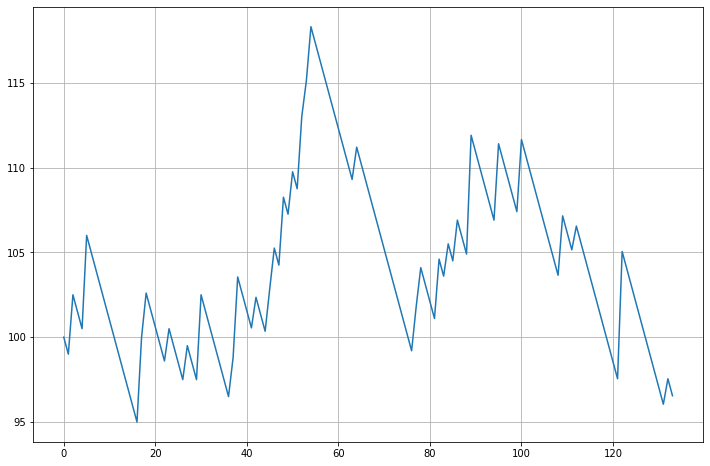

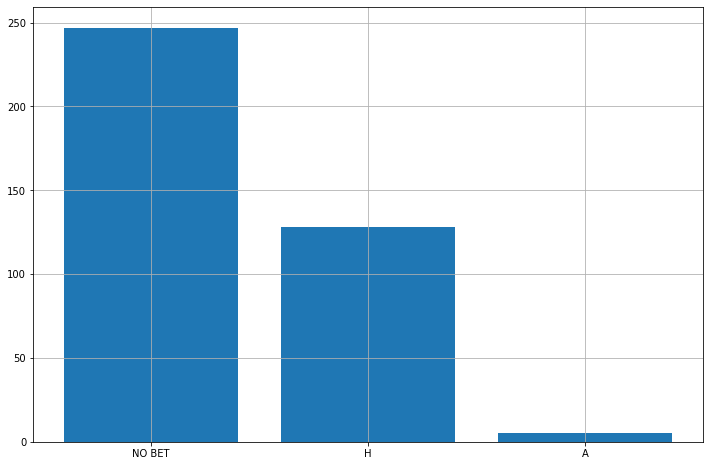

In [22]:
# Benchmarking value bets
my_bets["CHOICE"] = 'NO BET'
my_bets["GAIN_LOSS"] = np.nan

choices : List[str] = []
bet_size: float = 1.0
bankroll_real : float = 100.0
bankroll_theory : float = bankroll_real
bankroll_over_time : List[float] = [bankroll_real]
for index, row in my_bets.tail(N_BETS).iterrows():
  ev_home : float = bet_size * (row["B365H"] - 1) * row["PH"] - bet_size * (1 - row["PH"])
  ev_away : float = bet_size * (row["B365A"] - 1) * row["PA"] - bet_size * (1 - row["PA"])
  ev_tie : float = bet_size * (row["B365D"] - 1) * row["PD"] - bet_size * (1 - row["PD"])

  if max(ev_home, ev_away, ev_tie) < EV_CUTOFF:
    # Si no hay apuesta atractiva para hacer, no apostamos
    continue


  choice: str = ("H" if ev_home == max(ev_home, ev_away, ev_tie) else 
                "A" if ev_away == max(ev_home, ev_away, ev_tie) else
                "D")
  p_choice: float = row["PH"] if choice == "H" else row["PA"] if choice =="A" else "D"
  # if p_choice > 0.3 and p_choice < 0.6:
  #   continue
  choices.append(choice)

  my_bets.loc[index, "CHOICE"] = choice
  my_bets.loc[index, "P_CHOICE"] = p_choice
  

  delta_bankroll: float = -bet_size 

  if choice == "H" and row["FTHG"] > row["FTAG"]:
    delta_bankroll = bet_size * (row["B365H"] - 1)
    bankroll_real += bet_size * (row["B365H"] - 1)
  elif choice == "A" and row["FTHG"] < row["FTAG"]:
    delta_bankroll = bet_size * (row["B365A"] - 1)
    bankroll_real += bet_size * (row["B365A"] - 1)
  elif choice == "D" and row["FTHG"] == row["FTAG"]:
    delta_bankroll = bet_size * (row["B365D"] - 1)
    bankroll_real += bet_size * (row["B365D"] - 1)
  else:
    bankroll_real -= bet_size
  my_bets.loc[index, "GAIN_LOSS"] = delta_bankroll
  bankroll_over_time.append(bankroll_real)

print(bankroll_real)

plt.rcParams["figure.figsize"] = (12, 8)
plt.grid(True)
plt.title
plt.plot(bankroll_over_time)
plt.show()
plt.grid(True)
plt.bar(my_bets["CHOICE"].unique(), [my_bets.tail(N_BETS).loc[my_bets["CHOICE"] == choice, "CHOICE"].count() for choice in my_bets["CHOICE"].unique()])
plt.show()

df_aux = my_bets.tail(N_BETS)




In [23]:
import seaborn as sb
pdsql.sqldf(
  """
  SELECT  CHOICE,
          AVG(GAIN_LOSS) AS PROMEDIO,
          SUM(GAIN_LOSS) AS TOTAL,
          MAX(GAIN_LOSS) AS MAX_GAIN_LOSS,
          COUNT(GAIN_LOSS) AS CANTIDAD,
          CASE WHEN P_CHOICE > 0.6 THEN "SEGURA"
               WHEN P_CHOICE > 0.3 THEN "PAREJO"
               ELSE "LONG SHOT"  
          END AS PROBABLE
  FROM df_aux
  WHERE CHOICE NOT LIKE '%NO BET%'
  GROUP BY CHOICE, PROBABLE
  """
).head()

,CHOICE,PROMEDIO,TOTAL,MAX_GAIN_LOSS,CANTIDAD,PROBABLE
0,A,-1.000000,-5.00,-1.0,5,LONG SHOT
1,H,-1.000000,-1.00,-1.0,1,LONG SHOT
2,H,-0.007143,-0.85,7.5,119,PAREJO
3,H,0.425000,3.40,2.6,8,SEGURA


In [24]:
my_bets.tail(1)[["H_FORM", "A_FORM", "H_RATING", "A_RATING", "B365H", "B365A", "B365D", "PH", "PA", "PD"]]


,H_FORM,A_FORM,H_RATING,A_RATING,B365H,B365A,B365D,PH,PA,PD
match_id,,,,,,,,,,
379,LLLLLWLWWL,WWWDDWWLDD,1206.0,1283.0,11.0,1.3,6.0,0.470417,0.367268,0.162316
